# Simple CNN Model for Malaria Image Detection
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

![Malario](https://images3.memedroid.com/images/UPLOADED68/5c6b111fb1011.jpeg)

# 1.1 Data Preproc



1.1.1 Pseudo-Code

---

1. EDA 
2. Preproc Pipeline
3. Model Pipeline
4. Combine Pipeline
5. Train model on subset

---

In [28]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:
# imports 

import pandas as pd 
import numpy as np
import imageio as im
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.keras import layers

## 1.2 EDA (lite)

In [213]:
raw_data_dir = "../raw_data/malaria/cell_images"

os.listdir(raw_data_dir)

['.DS_Store', 'Parasitized', 'Uninfected']

In [214]:
parasitized = os.listdir(f"{raw_data_dir}/Parasitized")
uninfected = os.listdir(f"{raw_data_dir}/Uninfected")

# I know its hardcoded ...

In [215]:
parasitized[1]

'C189P150ThinF_IMG_20151203_142224_cell_84.png'

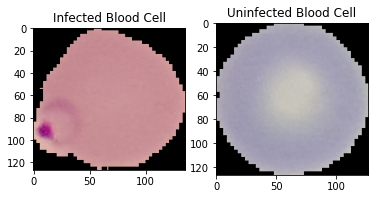

In [216]:
im1 = mpimg.imread(f"{raw_data_dir}/Parasitized/{parasitized[5]}")
im2 = mpimg.imread(f"{raw_data_dir}/Uninfected/{uninfected[5]}")
plt.subplot(1,2,1)
plt.imshow(im1)
plt.title("Infected Blood Cell")
plt.subplot(1,2,2)
plt.imshow(im2)
plt.title("Uninfected Blood Cell");

In [217]:
print(len(parasitized))
print("+---+")
print(len(uninfected))
print("+---+")
print(f"Ratio:{len(parasitized)/len(uninfected)}")

13781
+---+
13780
+---+
Ratio:1.0000725689404935


Dataset is balanced (Keep in mind, that in real life the ratio variates, but can be approximated with 1/1)

## 1.3 Dataset Creation and Split

In [218]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 16
height = 128
width = 128

data_train = image_dataset_from_directory(raw_data_dir, batch_size=batch_size, validation_split=0.2,image_size=(height, width), seed=42, subset="training")

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [219]:
data_val = image_dataset_from_directory(raw_data_dir, batch_size=batch_size, validation_split=0.2, image_size=(height, width), seed=42, subset="validation")

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [220]:
class_names = data_train.class_names

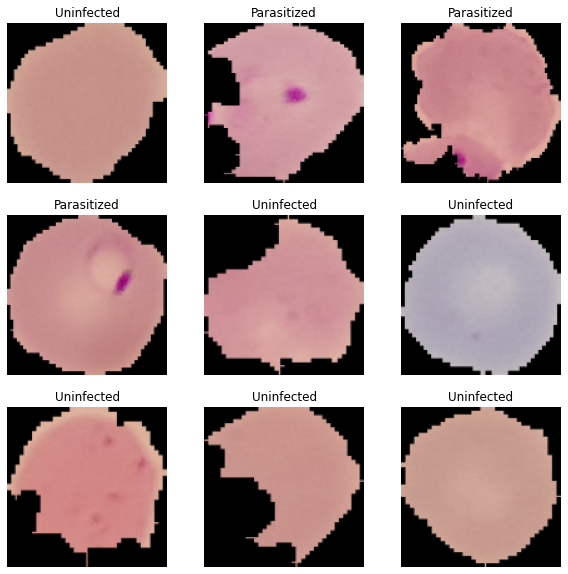

In [221]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# 2 Modeling

---

## 2.1 Baseline model

In [44]:
# Since the Dataset is balanced a baseline model would be guess one class on a 50% probabiity

base_acc = 0.5

# Model needs to beat 0.5 acc

## 2.2 Simple CNN Model

In [222]:
from tensorflow.keras import Sequential

model = Sequential()
model.add(layers.Rescaling(1/255,input_shape=(128,128,3)))
model.add(layers.Conv2D(16,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(32,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                    

In [224]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["Accuracy","Recall"])

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(data_train, validation_data=data_val, epochs=1, verbose=1, callbacks=es)

1378/1378 [==============================] - 201s 145ms/step - loss: 0.3855 - Accuracy: 0.8403 - recall: 0.8946 - val_loss: 0.1800 - val_Accuracy: 0.9376 - val_recall: 0.9707


In [58]:
def plotLearningCurve(history):
    plt.plot(history.history['Accuracy'])
    plt.plot(history.history['val_Accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Validation'],loc='upper left')
    plt.show()

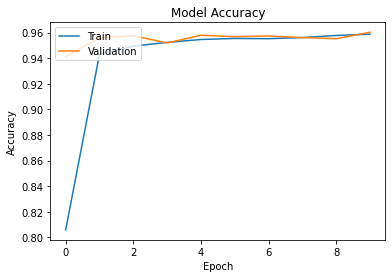

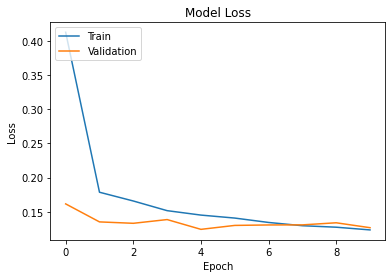

In [60]:
plotLearningCurve(history)

In [75]:
from tensorflow.keras.utils import img_to_array, load_img

In [245]:
X_pred = mpimg.imread("../raw_data/malaria/cell_images/Parasitized/C33P1thinF_IMG_20150619_120838a_cell_222.png")

In [246]:
X_pred.shape

(148, 145, 3)

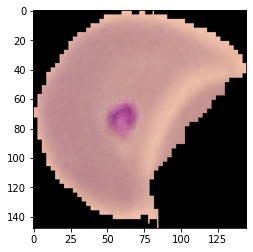

In [247]:
plt.imshow(X_pred);

In [248]:
from tensorflow.image import resize

X_pred = resize(X_pred, (128,128))
#X_pred = np.reshape(X_pred, (1,128,128,3))

In [249]:
X_pred.shape

TensorShape([128, 128, 3])

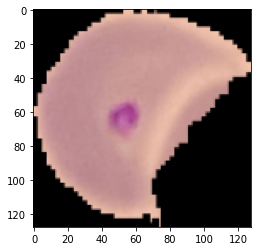

In [250]:
plt.imshow(X_pred);

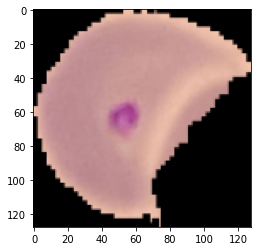

In [251]:
X_pred = np.reshape(X_pred,(1,128,128,3))
plt.imshow(X_pred[0]);

In [278]:
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

new_model = load_model("../../../../Downloads/saved_model/my_model")

In [279]:
for layer in new_model.layers:
    layer.trainable = False

In [280]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 activation_8 (Activation)   (None, 126, 126, 16)      0         
                                                                 
 dropout_8 (Dropout)         (None, 126, 126, 16)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        8224      
                                                                 
 activation_9 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                      

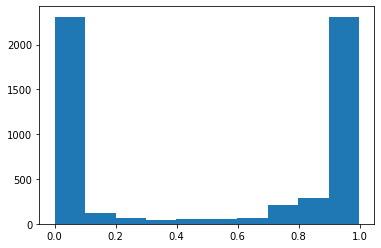

In [282]:
plt.hist(new_model.predict(data_val));